In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time

In [2]:

class Spike1d(torch.nn.Module):
    def __init__(self, n_in,n_out, thresh = 1, input_connections = [], mod = False):
        super(Spike1d, self).__init__()
        self.potentials = Parameter(torch.zeros(n_out, dtype=torch.float),requires_grad=False)
        self.thresh = thresh
        self.mod = mod
        self.n_out = n_out
        self.n_in = n_in
        try:
            self.fc =[nn.Linear(n_in,n_out,bias = False)]
            self.n_weight_matrices = 1
        except:
            fc = []
            for idx,i in enumerate(n_in):
                if idx in input_connections:
                    fc.append(0)
                else:
                    fc.append(nn.Linear(i,n_out,bias = False))
            
            self.fc = fc
                
    def get_empty_spikes(self):
        return torch.zeros([self.n_out])
    
    def get_n_inputs(self):
        return len(self.n_in)
    
    def forward(self, x):
        #update potentials
        delta_p = torch.zeros([self.n_out])
        for idx,f in enumerate(self.fc):
            try:
                #onlyt positive weights for now
                delta_p += torch.abs(f(x[idx]))
            except:
                delta_p += x[idx]
                
        self.potentials = Parameter(self.potentials + delta_p)
        
        #generate spikes
        spikes = (self.potentials >= self.thresh).float()
        
        #change potentials of spiked neurons
        if self.mod:
            #After spike overflow is kept
            self.potentials = Parameter(self.potentials - (spikes * self.thresh))
        else:
            #After spike potential is set to zero removing any overlow
            self.potentials = Parameter(self.potentials * (1 - spikes))
     
        return spikes, (self.potentials + spikes)

#A block of every other spiking layer (updates them all at once)
class Spike1d_block(torch.nn.Module):
    def __init__(self, layers):
        super(Spike1d_block, self).__init__()
        self.layers = layers
        
    def forward(self,in_spikes):
        out_spikes = []
        out_pots = []
        for idx,l in enumerate(self.layers):
            o, p = l(in_spikes[idx:idx + l.get_n_inputs() ])
            out_pots.append(p)
            out_spikes.append(o)
        
        return out_spikes, out_pots
    
    def get_empty_spikes(self):
        out = []
        for i in self.layers:
            out.append(i.get_empty_spikes())
        return out
class Net(torch.nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        self.spike1 = Spike1d([2,4],2, input_connections = [0])
        
        self.spike2 = Spike1d([2,4],4)
        
        self.spike3 = Spike1d([4],4)
        
        self.odd_layers = Spike1d_block([self.spike1,self.spike3])
        self.odd_layer_spikes = self.odd_layers.get_empty_spikes()
        self.even_layers =  Spike1d_block([self.spike2])
        self.even_layer_spikes = self.even_layers.get_empty_spikes()
       
    def forward(self, x):
        spikes = []
        
        #Update every odd layer
        self.odd_layer_spikes, pots = self.odd_layers([x] + self.even_layer_spikes)
        spikes.append(pots)
     
        #Update every even layer
        self.even_layer_spikes, pots = self.even_layers(self.odd_layer_spikes)
        spikes.append(pots)
                
        return x, spikes


<IPython.core.display.Javascript object>


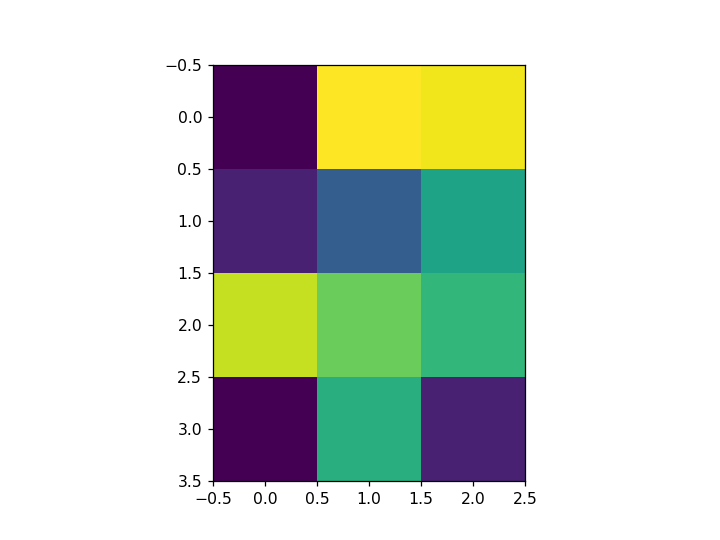

In [3]:
model = Net(mod = False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

def draw_spikes(spikes, ax, l_dim = 4, n_layers = 3):
 
    spikes_ = torch.zeros(3,l_dim) - 0.1
    
    even = 0
    odd = 0
    e = 0
    while True:
        e += 1
        if e % 2 != 0:
            spike_block = spikes[0]
            
            i = odd
            odd += 1
        else:
            spike_block = spikes[1]
            
            i = even
            even += 1
        
        try:
            d = (l_dim - spike_block[i].shape[0]) // 2
            try:
                spikes_[e-1][d:spike_block[i].shape[0] + d] = spike_block[i].clone().detach()
            except:
                spikes_[e-1][d:spike_block[i].shape[0] + d] = torch.tensor(spike_block[i])
        except:
            break
        
        
    spikes_ = spikes_.t()
    
    ax.clear()
    ax.imshow(spikes_,vmin=-0.1, vmax=1)
    

x_fire = np.array(random.sample(range(1,150), 15))
y_fire =[]# x_fire + 2

for e in range(150):
    in_stream = torch.tensor([e in x_fire,e in y_fire], dtype=torch.float)
    
    out,spikes = model(in_stream)
    #spikes = [spikes[0][0], spikes[1][0]]
    draw_spikes(spikes, ax, l_dim = 4, n_layers = 3)
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    fig.canvas.draw()
    time.sleep(0.1)

In [4]:
max(len(x) for x in [[1],[1,2]] ) 

2